In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns # heatmaps yay

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from scipy.stats import skew
from scipy.stats import norm
from scipy.stats import boxcox

from scipy.special import inv_boxcox

import math

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
lmbda_opts = {}

In [3]:
def drop_high_missing_features(df):
    tot_rec = len(df.index)
    for col in df.columns.values:
        if df[col].isnull().sum() / tot_rec > 0.15:
            del df[col]

def impute_missing_data(df):
    fill_with = {'None': ['PoolQC', 'MiscFeature', 'Alley', 'Fence',
                 'FireplaceQu', 'GarageType', 'GarageFinish',
                 'GarageQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'],
               0: ['GarageYrBlt', 'GarageArea', 'GarageCars',
                   'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                   'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                   'MasVnrArea'
                  ]}
    for fw in fill_with:
        for f in fill_with[fw]:
            df[f] = df[f].fillna(fw)
    
    
    df["Functional"] = df["Functional"].fillna("Typ")
    
    
    mode_list = ['SaleType', 'Exterior2nd', 'Exterior1st', 'KitchenQual', 
                 'Electrical', 'MSZoning']
    for f in mode_list:
        df[f] = df[f].fillna(df[f].mode()[0])
    
    
    df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    
    return df

def calculate_nulls(df):
    df_nulls = df.copy().isnull().sum()
    df_nulls = df_nulls.to_frame().rename(columns={0:'num_nulls'})
    df_nulls['total_records'] = len(df.index)
    df_nulls['pct_null'] = df_nulls['num_nulls'] / df_nulls['total_records'] * 100
    df_nulls = df_nulls[df_nulls['num_nulls'] > 0].sort_values(by='pct_null', ascending=False)
    return df_nulls

def process_df(df, is_test=False):
    df.set_index('Id')

    df = impute_missing_data(df)
    
    df = df.drop(['Utilities'], axis=1)

    # Convert to strings as they're categories:
    str_cols = ['MSSubClass', 'OverallCond', 'MoSold', 'YrSold', 'YearRemodAdd', 'YearBuilt', 'GarageYrBlt']
    for f in str_cols:
        df[f] = df[f].astype(str)

    ohe_cols = df.dtypes[df.dtypes == "object"].index
    df_dummies = pd.get_dummies(df[ohe_cols])
    df = df.drop(ohe_cols, axis='columns')
    df = pd.concat([df, df_dummies], sort=False, axis='columns')

    # Use a label encoder for the categorical fields
    le_cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
           'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
           'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
           'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
           'MoSold', 'YrSold', 'YearRemodAdd', 'YearBuilt', 'GarageYrBlt']
    for c in le_cols:
        if c in df.columns.values:
            le = LabelEncoder() 
            le.fit(list(df[c].values)) 
            df[c] = le.transform(list(df[c].values))
        
    numeric_feats = df.dtypes[df.dtypes != "object"].index.values        
    df = df.loc[:, numeric_feats]
        
    # Sale Price is in our training data, but not testing data
    shift = 1.0
    if 'SalePrice' in df.columns.values:
        filter = (df['GrLivArea'] > 4000) & (df['SalePrice'] < 200000)
        df = df.loc[~filter, :]

        # Check the skew of all numerical features
        skewed_feats = df[numeric_feats[1:]].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
        skewness = pd.DataFrame({'Skew' :skewed_feats})
        
        for f in skewness[abs(skewness) > 0.75].index:
            if f not in le_cols and '_' not in f: #ignore label encoded fields and OHE columns
                df[f], lmbda_opts[f] = boxcox(df[f] + shift)

    else:  # Test data
        for f in lmbda_opts:
            if f in df.columns:
                df[f] = boxcox(df[f] + shift, lmbda=lmbda_opts[f])
            elif f != 'SalePrice':
                df[f] = 0

    return df

In [4]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix Without Normalization')
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [5]:
from sklearn.preprocessing import LabelEncoder

def encode_text_index(df, name):
    le = LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

In [6]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

def show_results(clf, X, y):
    acc_score = clf.score(X, y)
    print('Accuracy: {}'.format(acc_score*100))
    
    y_pred = clf.predict(X)
    cm_matrix = confusion_matrix(y, y_pred)
    np.set_printoptions(precision=2)
    
    Class = encode_text_index(pd.DataFrame(y), y.columns[0])
    
    fig = plt.figure()
    plot_confusion_matrix(cm_matrix, classes=Class, normalize=True)
    plt.show()
    
    y_pred = clf.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
    
    fig = plt.figure()
    lw = 2
    
    plt.plot(fpr, tpr, color='red', lw=lw, label='ROC Curve (area = {:%0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right', frameon=False)
    
    plt.show()
    

In [7]:
def run_skm(model, X_train, y_train, X_test, y_test, X_pred, model_params={}):
    cn = type(model).__name__
    print(f"Model: {cn}")
    model.fit(X_train, y_train, **model_params)
    y_test_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_test_pred)
    model_score = model.score(X_train, y_train)
    print(f"Root Mean Squared Error: {math.sqrt(mse)} - Score: {model_score}")
    
    y_pred = model.predict(X_pred)
    
    df_sub = pd.DataFrame(y_pred, index=X_pred['Id'], columns=['SalePrice'])
    df_sub['SalePrice'] = inv_boxcox(df_sub['SalePrice'], lmbda_opts['SalePrice'])
    df_sub.to_csv(os.path.join('submissions', f"{cn}.{datetime.now():%Y%M%d_%H%m%s}.csv"))
    return y_pred
    

#### Import the train csv file to take a look at the data

In [8]:
df = pd.read_csv(os.path.join('data','train.csv'))

In [9]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


How many records are we dealing with?

In [10]:
len(df.index)

1460

#### Determine which features are important

How much of each feature is null?

In [11]:
calculate_nulls(df)

,num_nulls,total_records,pct_null
PoolQC,1453,1460,99.520548
MiscFeature,1406,1460,96.301370
Alley,1369,1460,93.767123
Fence,1179,1460,80.753425
FireplaceQu,690,1460,47.260274
LotFrontage,259,1460,17.739726
GarageType,81,1460,5.547945
GarageYrBlt,81,1460,5.547945
GarageFinish,81,1460,5.547945
GarageQual,81,1460,5.547945


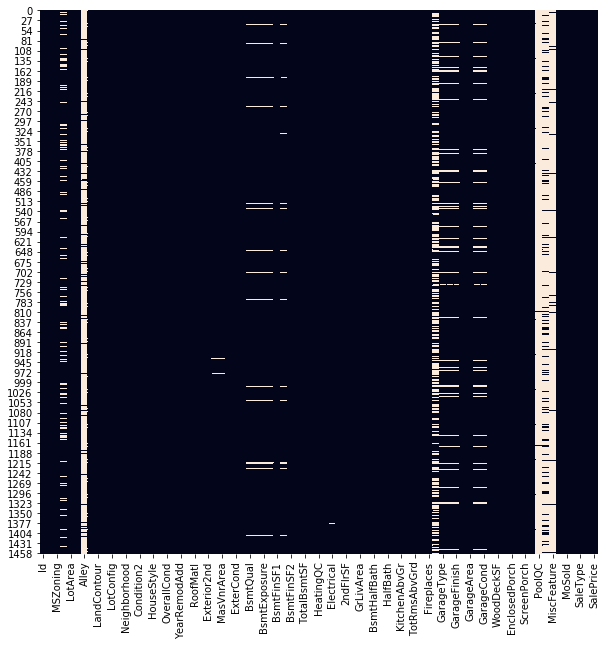

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.isnull(), cbar=False, ax=ax)

Another interesting note is that the GarageX type features all have the same amount of null values. This is likely because they're a part of the same records. We can verify this to see how many records have all those features set to null.

Next let's take a look at the correlations between each feature.

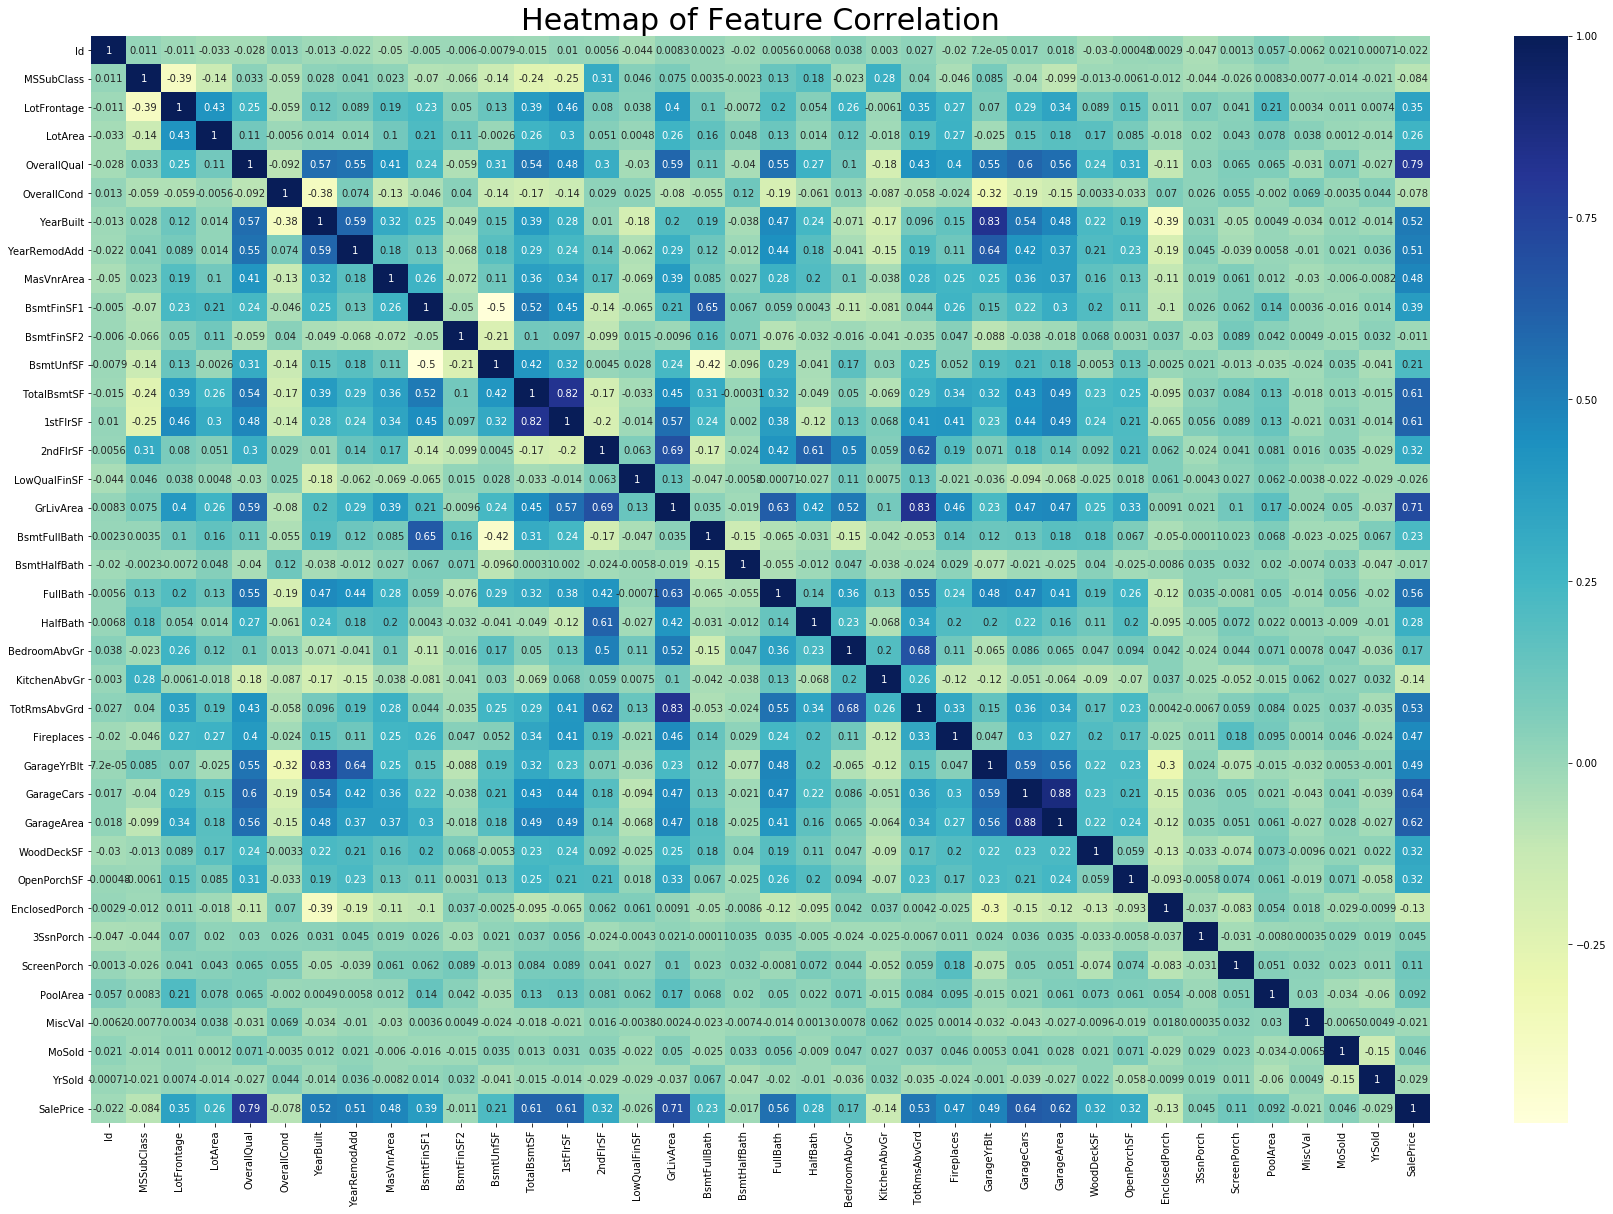

In [13]:
plt.subplots(figsize = (30,20))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True);
plt.title("Heatmap of Feature Correlation", fontsize = 30);

Looking at the correlation heat map we can quickly identify features which are highly related to other features. For example 1stFlSF and TotalBsmntSF are highly correlated which makes sense because generally speaking most basements are full basements (the basement is wearing the first floor like a hat). The same goes for 1stFlSF and 2ndFlSF (This house is a mad hatter).

Another instance is GarageCars and GarageArea. This makes sense because you need more space to store more cars. This is the same rationale for TotRmsAbvGrd (Total rooms above ground) and GrLivArea (ground floor living area).

YearBuilt and GarageYrBlt also appear to be highly correlated. This makes sense because typically the house and the garage are built at the same time.

Let's take some time to graph some of these relationships and see what comes up.

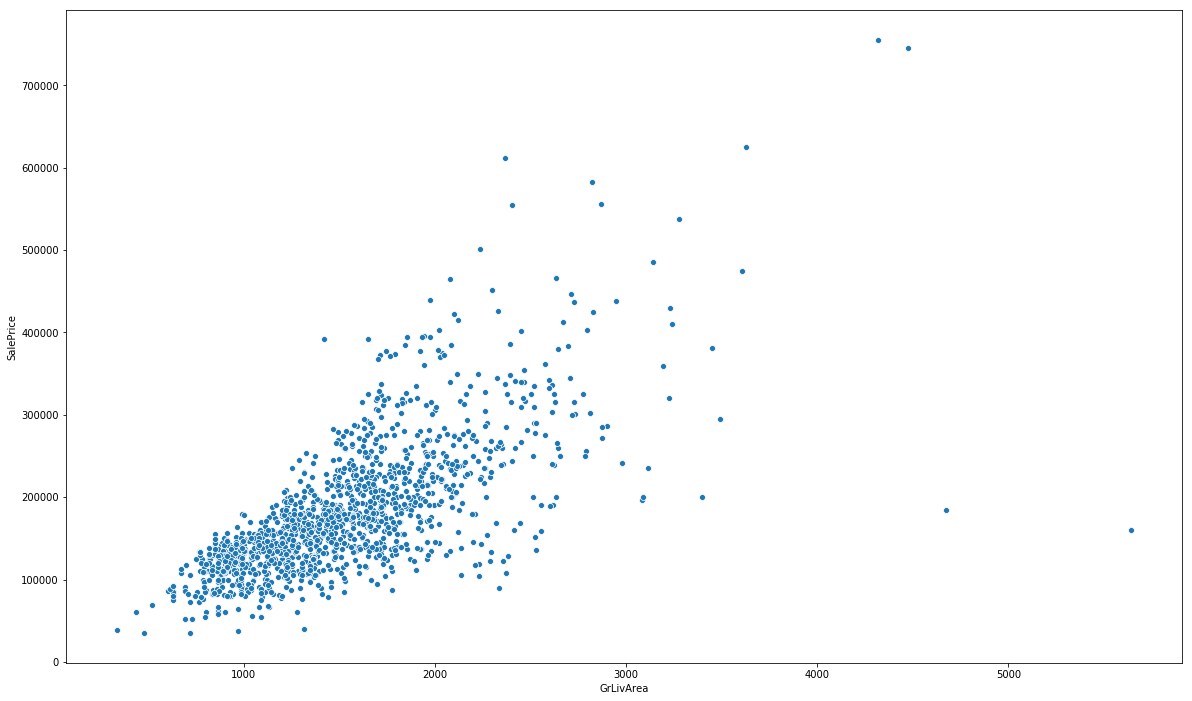

In [14]:
plt.subplots(figsize = (20,12))
sns.scatterplot(x=df['GrLivArea'], y= df['SalePrice']);

In [15]:
filter = (df['GrLivArea'] > 4000) & (df['SalePrice'] < 200000)
df[filter][['GrLivArea', 'SalePrice']]

,GrLivArea,SalePrice
523,4676,184750
1298,5642,160000


As we can see from the graph there are four possible outliers, two with a sale price over $700,000 and two with over 4500 sq. ft. but a much lower price. If we follow the trend of the graph the higher two outliers seem to fit the pattern and we can likely keep these two in however we should probably remove the other two outliers. As this is unique to the training dataset we'll do that below.

In [16]:
df = df[~filter]

In [17]:
mask = df['Electrical'].notna()
df = df.loc[(mask), :]

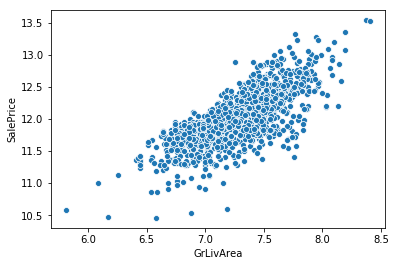

In [18]:
sns.scatterplot(np.log(df['GrLivArea']), np.log(df['SalePrice']));

The Box-Cox test quickly and easily tells us if  we need to perform a transform on our data or not by telling us a lambda value:

* -1. is a reciprocal
* -.5 is a recriprocal square root
* 0.0 is a log transformation
* .5 is a square root transform and
* 1.0 is no transform.

It's important that our data be transformed into a normal distribution as most regression models require the data to be normally distributed.

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:900: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2308: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1926: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


LotArea lambda = -12.7707
TotalBsmtSF lambda = 0.802181
1stFlrSF lambda = -0.00632014
2ndFlrSF lambda = -0.129571
GrLivArea lambda = 0.0696751
GarageArea lambda = 0.817641
SalePrice lambda = -0.0771598


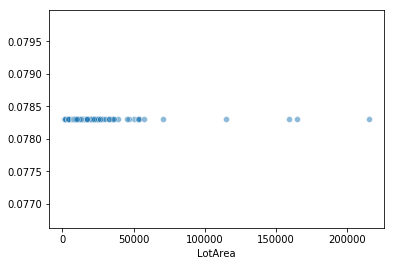

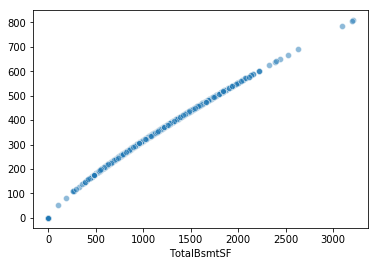

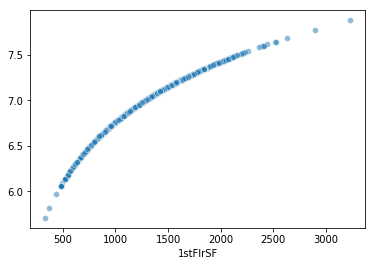

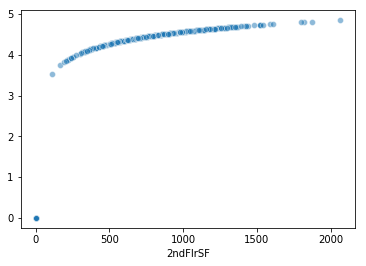

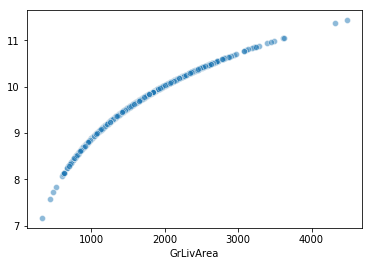

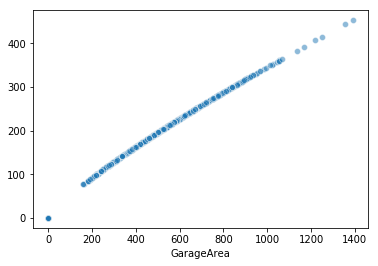

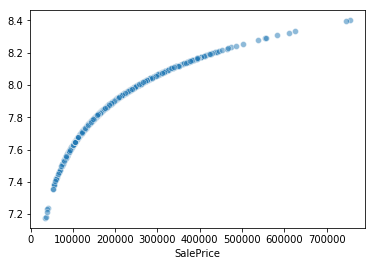

In [19]:
bc_list = ['LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'SalePrice']

for c in bc_list:
    xt, maxlog = boxcox(df[c] + 1)
    fig = plt.figure()
    sns.scatterplot(df[c], xt, alpha=0.5);

    print("{} lambda = {:g}".format(c, maxlog))
    
    #plt.show_legend()

Based on the Box-Cox test we ran on the columns from our dataset, we need to perform the following transformations in our `process_df` function:

- Log
  - LotArea
  - 1stFlrSF
  - 2ndFlrSF
  - SalePrice
  - GrLivArea

- Square root
  - TotalBsmtSF
  - GarageArea
  

Alternatively we can just use the transformed data (`xt` above) returned by the `boxcox` function.

In [20]:
df = pd.read_csv(os.path.join('data','train.csv'))
df = process_df(df)

/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1929: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)


In [21]:
df.head()

,Id,LotFrontage,LotArea,OverallQual,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,YearBuilt_1872,YearBuilt_1875,YearBuilt_1880,YearBuilt_1882,YearBuilt_1885,YearBuilt_1890,YearBuilt_1892,YearBuilt_1893,YearBuilt_1898,YearBuilt_1900,YearBuilt_1904,YearBuilt_1905,YearBuilt_1906,YearBuilt_1908,YearBuilt_1910,YearBuilt_1911,YearBuilt_1912,YearBuilt_1913,YearBuilt_1914,YearBuilt_1915,YearBuilt_1916,YearBuilt_1917,YearBuilt_1918,YearBuilt_1919,YearBuilt_1920,YearBuilt_1921,YearBuilt_1922,YearBuilt_1923,YearBuilt_1924,YearBuilt_1925,YearBuilt_1926,YearBuilt_1927,YearBuilt_1928,YearBuilt_1929,YearBuilt_1930,YearBuilt_1931,YearBuilt_1932,YearBuilt_1934,YearBuilt_1935,YearBuilt_1936,YearBuilt_1937,YearBuilt_1938,YearBuilt_1939,YearBuilt_1940,YearBuilt_1941,YearBuilt_1942,YearBuilt_1945,YearBuilt_1946,YearBuilt_1947,YearBuilt_1948,YearBuilt_1949,YearBuilt_1950,YearBuilt_1951,YearBuilt_1952,YearBuilt_1953,YearBuilt_1954,YearBuilt_1955,YearBuilt_1956,YearBuilt_1957,YearBuilt_1958,YearBuilt_1959,YearBuilt_1960,YearBuilt_1961,YearBuilt_1962,YearBuilt_1963,YearBuilt_1964,YearBuilt_1965,YearBuilt_1966,YearBuilt_1967,YearBuilt_1968,YearBuilt_1969,YearBuilt_1970,YearBuilt_1971,YearBuilt_1972,YearBuilt_1973,YearBuilt_1974,YearBuilt_1975,YearBuilt_1976,YearBuilt_1977,YearBuilt_1978,YearBuilt_1979,YearBuilt_1980,YearBuilt_1981,YearBuilt_1982,YearBuilt_1983,YearBuilt_1984,YearBuilt_1985,YearBuilt_1986,YearBuilt_1987,YearBuilt_1988,YearBuilt_1989,YearBuilt_1990,YearBuilt_1991,YearBuilt_1992,YearBuilt_1993,YearBuilt_1994,YearBuilt_1995,YearBuilt_1996,YearBuilt_1997,YearBuilt_1998,YearBuilt_1999,YearBuilt_2000,YearBuilt_2001,YearBuilt_2002,YearBuilt_2003,YearBuilt_2004,YearBuilt_2005,YearBuilt_2006,YearBuilt_2007,YearBuilt_2008,YearBuilt_2009,YearBuilt_2010,YearRemodAdd_1950,YearRemodAdd_1951,YearRemodAdd_1952,YearRemodAdd_1953,YearRemodAdd_1954,YearRemodAdd_1955,YearRemodAdd_1956,YearRemodAdd_1957,YearRemodAdd_1958,YearRemodAdd_1959,YearRemodAdd_1960,YearRemodAdd_1961,YearRemodAdd_1962,YearRemodAdd_1963,YearRemodAdd_1964,Yea

In [22]:
from sklearn.model_selection import train_test_split

y = df.pop('SalePrice')
X = df

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=8675309)

In [23]:
X_train.dtypes

Id                         int64
LotFrontage              float64
LotArea                  float64
OverallQual              float64
MasVnrArea               float64
BsmtFinSF1               float64
BsmtFinSF2               float64
BsmtUnfSF                float64
TotalBsmtSF              float64
1stFlrSF                 float64
2ndFlrSF                 float64
LowQualFinSF             float64
GrLivArea                float64
BsmtFullBath             float64
BsmtHalfBath             float64
FullBath                 float64
HalfBath                 float64
BedroomAbvGr             float64
KitchenAbvGr             float64
TotRmsAbvGrd             float64
Fireplaces               float64
GarageCars               float64
GarageArea               float64
WoodDeckSF               float64
OpenPorchSF              float64
EnclosedPorch            float64
3SsnPorch                float64
ScreenPorch              float64
PoolArea                 float64
MiscVal                  float64
MSSubClass

In [24]:
features = ['LotArea', 
            '1stFlrSF',
            '2ndFlrSF',
            'GrLivArea',
            'TotalBsmtSF',
            'GarageArea',
            'YearBuilt',
            'FullBath',
            'BedroomAbvGr',
            'OverallQual']

# XGBoost

In [25]:
import xgboost as xgb

In [26]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [27]:
param = {'objective': 'reg:linear', 'max_depth': 100, 'lambda': 0.5, 'alpha': 0.5, 'eta': 1} #, 'eval_metric': 'auc'
evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 1000

In [28]:
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[20:19:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[0]	train-rmse:0.158717	eval-rmse:0.154736
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[20:19:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=25
[1]	train-rmse:0.062248	eval-rmse:0.087564
[20:19:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=41
[2]	train-rmse:0.042294	eval-rmse:0.08402
[20:19:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=71
[3]	train-rmse:0.033961	eval-rmse:0.083002
[20:19:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=50
[4]	train-rmse:0.027391	eval-rmse:0.083321
[20:19:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extr

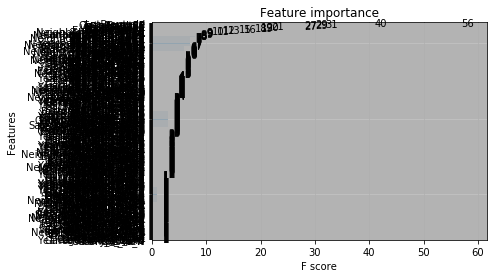

In [29]:
xgb.plot_importance(bst)

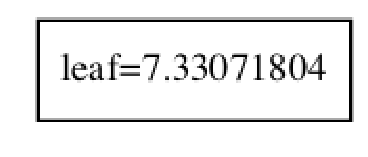

In [30]:
xgb.plot_tree(bst)

In [31]:
from sklearn.metrics import mean_squared_error

In [32]:
dtest = xgb.DMatrix(X_test)
ypred = bst.predict(dtest)

In [33]:
mse = mean_squared_error(y_test, ypred)
print(f"Root Mean Squared Error: {math.sqrt(mse)}")

Root Mean Squared Error: 0.0849305626600561


In [34]:
bst.best_score

0.083002

In [35]:
df_pred = pd.read_csv(os.path.join('data','test.csv'))
df_pred = process_df(df_pred, is_test=True)

c_in_train = [c for c in df_pred.columns.values if c in X_train]
c_nin_pred = [c for c in X_train.columns.values if c not in df_pred]

df_pred = df_pred.loc[:, c_in_train]

for c in c_nin_pred:
    df_pred[c] = 0
    
df_pred = df_pred[X_train.columns]

In [36]:
df_pred.head()

,Id,LotFrontage,LotArea,OverallQual,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,YearBuilt_1872,YearBuilt_1875,YearBuilt_1880,YearBuilt_1882,YearBuilt_1885,YearBuilt_1890,YearBuilt_1892,YearBuilt_1893,YearBuilt_1898,YearBuilt_1900,YearBuilt_1904,YearBuilt_1905,YearBuilt_1906,YearBuilt_1908,YearBuilt_1910,YearBuilt_1911,YearBuilt_1912,YearBuilt_1913,YearBuilt_1914,YearBuilt_1915,YearBuilt_1916,YearBuilt_1917,YearBuilt_1918,YearBuilt_1919,YearBuilt_1920,YearBuilt_1921,YearBuilt_1922,YearBuilt_1923,YearBuilt_1924,YearBuilt_1925,YearBuilt_1926,YearBuilt_1927,YearBuilt_1928,YearBuilt_1929,YearBuilt_1930,YearBuilt_1931,YearBuilt_1932,YearBuilt_1934,YearBuilt_1935,YearBuilt_1936,YearBuilt_1937,YearBuilt_1938,YearBuilt_1939,YearBuilt_1940,YearBuilt_1941,YearBuilt_1942,YearBuilt_1945,YearBuilt_1946,YearBuilt_1947,YearBuilt_1948,YearBuilt_1949,YearBuilt_1950,YearBuilt_1951,YearBuilt_1952,YearBuilt_1953,YearBuilt_1954,YearBuilt_1955,YearBuilt_1956,YearBuilt_1957,YearBuilt_1958,YearBuilt_1959,YearBuilt_1960,YearBuilt_1961,YearBuilt_1962,YearBuilt_1963,YearBuilt_1964,YearBuilt_1965,YearBuilt_1966,YearBuilt_1967,YearBuilt_1968,YearBuilt_1969,YearBuilt_1970,YearBuilt_1971,YearBuilt_1972,YearBuilt_1973,YearBuilt_1974,YearBuilt_1975,YearBuilt_1976,YearBuilt_1977,YearBuilt_1978,YearBuilt_1979,YearBuilt_1980,YearBuilt_1981,YearBuilt_1982,YearBuilt_1983,YearBuilt_1984,YearBuilt_1985,YearBuilt_1986,YearBuilt_1987,YearBuilt_1988,YearBuilt_1989,YearBuilt_1990,YearBuilt_1991,YearBuilt_1992,YearBuilt_1993,YearBuilt_1994,YearBuilt_1995,YearBuilt_1996,YearBuilt_1997,YearBuilt_1998,YearBuilt_1999,YearBuilt_2000,YearBuilt_2001,YearBuilt_2002,YearBuilt_2003,YearBuilt_2004,YearBuilt_2005,YearBuilt_2006,YearBuilt_2007,YearBuilt_2008,YearBuilt_2009,YearBuilt_2010,YearRemodAdd_1950,YearRemodAdd_1951,YearRemodAdd_1952,YearRemodAdd_1953,YearRemodAdd_1954,YearRemodAdd_1955,YearRemodAdd_1956,YearRemodAdd_1957,YearRemodAdd_1958,YearRemodAdd_1959,YearRemodAdd_1960,YearRemodAdd_1961,YearRemodAdd_1962,YearRemodAdd_1963,YearRemodAdd_1964,YearRemodAdd_

In [37]:
dpred = xgb.DMatrix(df_pred)
ypred = bst.predict(dpred)

In [38]:
df_sub = pd.DataFrame(ypred, index=df_pred['Id'], columns=['SalePrice'])

In [39]:
df_sub['SalePrice'] = inv_boxcox(df_sub['SalePrice'], lmbda_opts['SalePrice'])

In [40]:
now = datetime.now()
df_sub.to_csv(os.path.join('submissions', f'XGBoost_{now:%Y%m%d%H%M%S}.csv'))

## Scikit Learn Models

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import PassiveAggressiveRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.tree import DecisionTreeRegressor


lr = LinearRegression()
en = ElasticNet()

rfr = RandomForestRegressor(n_estimators=100)
gbr = GradientBoostingRegressor()

dtr = DecisionTreeRegressor()



models = [lr, en, rfr, gbr, dtr]

In [42]:
calculate_nulls(df_pred)

,num_nulls,total_records,pct_null


In [43]:
df_pred.describe().loc['max'].T.sort_values(ascending=False)

Id                       2919.000000
TotalBsmtSF              1169.595533
GarageArea                479.439401
BsmtUnfSF                  76.464068
LotFrontage                31.788294
BsmtFinSF1                 25.047626
GrLivArea                  11.653532
1stFlrSF                    8.260725
GarageCars                  7.537597
OpenPorchSF                 6.867259
OverallQual                 6.409297
WoodDeckSF                  5.505564
BedroomAbvGr                5.499222
2ndFlrSF                    4.819458
MasVnrArea                  3.365251
FullBath                    3.202070
TotRmsAbvGrd                3.181045
Fireplaces                  1.199163
YearBuilt_1985              1.000000
YearBuilt_1991              1.000000
YearBuilt_1990              1.000000
YearBuilt_1989              1.000000
YearBuilt_1988              1.000000
YearBuilt_1987              1.000000
YearBuilt_1986              1.000000
YearBuilt_1982              1.000000
YearBuilt_1984              1.000000
Y

In [44]:
calculate_nulls(X_test)

,num_nulls,total_records,pct_null


In [45]:
for model in models:
    try:
        run_skm(model, X_train, y_train, X_test, y_test, df_pred)
    except Exception as e:
        print(f'Error with model {model} - {e}')
        

Model: LinearRegression
Root Mean Squared Error: 229338.36298354188 - Score: 0.9706394972917418
Model: ElasticNet
Root Mean Squared Error: 0.10702099304567048 - Score: 0.5797180815696883
Model: RandomForestRegressor
Root Mean Squared Error: 0.06066970065142984 - Score: 0.9818912228323011
Model: GradientBoostingRegressor
Root Mean Squared Error: 0.05511261829170256 - Score: 0.9597686297501085
Model: DecisionTreeRegressor
Root Mean Squared Error: 0.08926544632586701 - Score: 0.9999999389058268
